In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt




In [2]:
class TwoChannelsToComplex(nn.Module):
    def __init__(self):
        super(TwoChannelsToComplex, self).__init__()

    def forward(self, x):
        real, imag = torch.chunk(x, 2, dim=1)
        complex_tensor = torch.complex(real.squeeze(1), imag.squeeze(1))
        return complex_tensor
class ComplexToTwoChannels(nn.Module):
    def __init__(self):
        super(ComplexToTwoChannels, self).__init__()

    def forward(self, x):
        real = x.real.unsqueeze(1)
        imag = x.imag.unsqueeze(1)
        two_channel_tensor = torch.cat((real, imag), dim=1)
        return two_channel_tensor

class InverseFourierTransform2D(nn.Module):
    def __init__(self, norm='ortho'):
        super(InverseFourierTransform2D, self).__init__()
        self.norm = norm

    def forward(self, x):
        return torch.fft.ifft2(x, norm=self.norm)

#  Download the Fashion MNIST dataset

In [3]:


transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

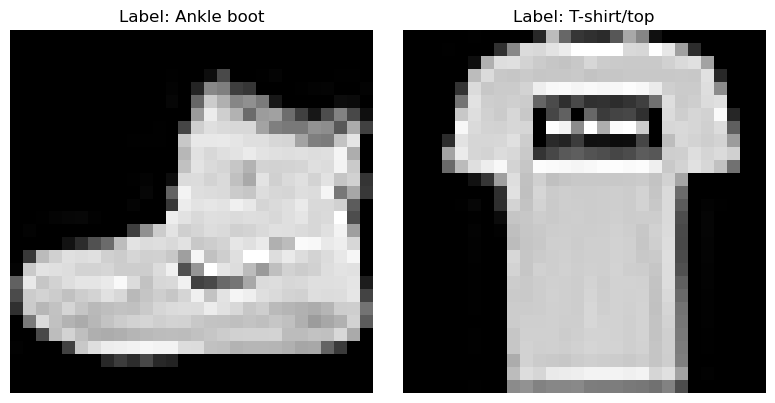

torch.Size([1, 28, 28])

In [4]:

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for i in range(2):
    image, label = train_data[i]
    ax[i].imshow(image.squeeze(), cmap='gray')
    ax[i].set_title(f"Label: {train_data.classes[label]}")
    ax[i].axis('off')
plt.tight_layout()
plt.show()
image.shape

# Perform the Fourier Transform on all data

In [5]:

def fft_transform(data):
    fft_data = []
    for img, _ in data:
        fft = np.fft.fft2(img.numpy().squeeze())
        fft_data.append(fft)
    return np.array(fft_data)

train_fft = fft_transform(train_data)
test_fft = fft_transform(test_data)





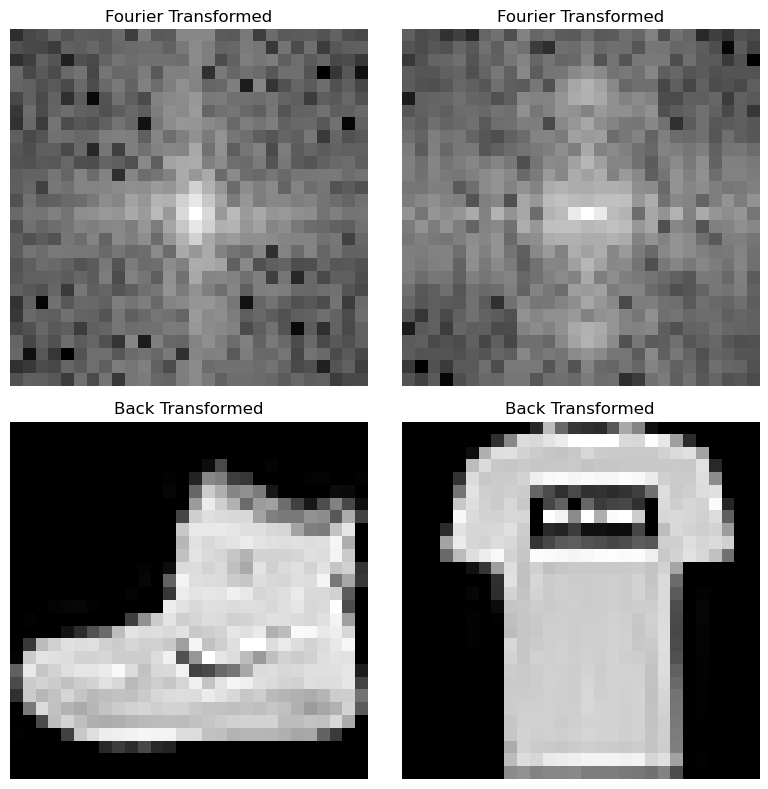

In [6]:
# 4. Plot Fourier transformed and back-transformed examples
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
for i in range(2):
    ax[0, i].imshow(np.log(np.abs(np.fft.fftshift(train_fft[i]))), cmap='gray')
    ax[0, i].set_title("Fourier Transformed")
    ax[0, i].axis('off')
    
    back_transformed = np.fft.ifft2(train_fft[i]).real
    ax[1, i].imshow(back_transformed, cmap='gray')
    ax[1, i].set_title("Back Transformed")
    ax[1, i].axis('off')
plt.tight_layout()
plt.show()

# Create dataset

In [7]:
def create_complex_dataset(data, labels):
    real_data = np.real(data)
    imag_data = np.imag(data)
    complex_data = np.stack((real_data, imag_data), axis=1)
    complex_tensor = torch.from_numpy(complex_data).float()
    label_tensor = torch.tensor(labels)
    print(len(complex_tensor), len(label_tensor))
    return torch.utils.data.TensorDataset(complex_tensor, label_tensor)

train_labels = [label for _, label in train_data]
train_dataset = create_complex_dataset(train_fft, train_labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

test_labels = [label for _, label in test_data]
test_dataset = create_complex_dataset(test_fft, test_labels)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

print(len(train_loader))

60000 60000
10000 10000
938


torch.Size([2, 28, 28])


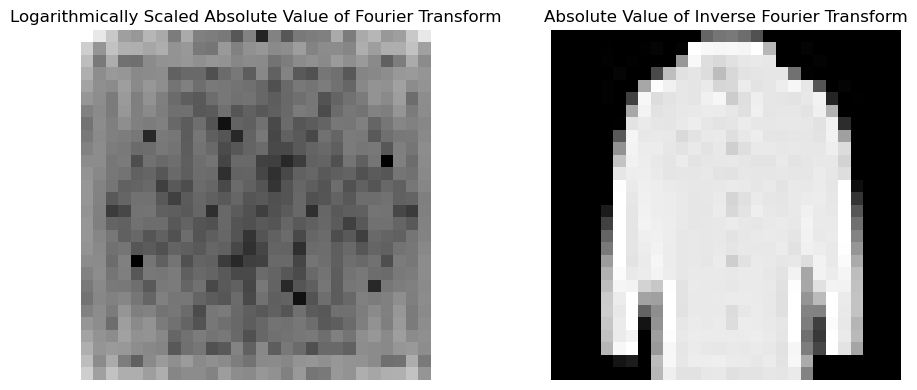

In [9]:
# Load one sample from the test loader
test_sample, test_label = next(iter(test_loader))

# Get the first sample from the batch
test_sample = test_sample[14]
print(test_sample.shape)
test_sample = torch.complex(test_sample[0], test_sample[1])
# Compute the absolute value and apply logarithmic scaling
abs_fft = torch.abs(test_sample)
log_abs_fft = torch.log(abs_fft + 1e-7)  # Add a small constant to avoid taking log of zero

# Compute the inverse Fourier transform
ifft_sample = torch.fft.ifft2(test_sample)
ifft_abs = torch.abs(ifft_sample)

# Create a new figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot the logarithmically scaled absolute value of the Fourier transform
ax1.imshow(log_abs_fft.squeeze(), cmap='gray')
ax1.set_title("Logarithmically Scaled Absolute Value of Fourier Transform")
ax1.axis('off')

# Plot the absolute value of the inverse Fourier transform
ax2.imshow(ifft_abs.squeeze(), cmap='gray')
ax2.set_title("Absolute Value of Inverse Fourier Transform")
ax2.axis('off')

plt.tight_layout()
plt.show()

In [10]:

class FourierDecisionLayer(nn.Module):
    def __init__(self, num_channels):
        super(FourierDecisionLayer, self).__init__()
        self.decision_vector = nn.Parameter(torch.randn(num_channels))
        self.linear = nn.Conv2d(2, 1, kernel_size=1)  # Linear layer to combine real and imaginary parts

    def forward(self, x):
        # Apply sigmoid to get values between 0 and 1
        decisions = torch.sigmoid(self.decision_vector)
        
        # Create a mask for channels where decision > 0.5
        mask = (decisions > 0.5).float()
        
        # Apply FFT to the input
        x_fft = torch.fft.fft2(x)
        
        # Separate real and imaginary parts
        real_part = x_fft.real
        imag_part = x_fft.imag
        
        # Combine real and imaginary parts into a single tensor
        fft_features = torch.cat([real_part, imag_part], dim=1)
        
        # Apply linear layer to combine real and imaginary parts
        fft_combined = self.linear(fft_features)
        
        # Combine FFT and original based on the mask
        output = mask.view(1, -1, 1, 1) * fft_combined + (1 - mask.view(1, -1, 1, 1)) * x
        
        return output

# Network Structures

In [11]:
class FourierCNN(nn.Module):
    def __init__(self):
        super(FourierCNN, self).__init__()

        self.conv1 = nn.Conv2d(2, 32, 3, 1)
        self.fourierDecision = FourierDecisionLayer(32)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return nn.functional.log_softmax(x, dim=1)

model = FourierCNN()


In [13]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 1200205


# Train Loop

In [14]:
from tqdm import tqdm
# 7. Train the network on the Fourier transformed data
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}", unit="batch")
    for batch_idx, (data, target) in enumerate(progress_bar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        progress_bar.set_postfix({"Train Loss": train_loss / (batch_idx + 1), "Train Acc": 100. * correct / total})
    
    train_loss /= len(train_loader)
    train_accuracy = 100. * correct / total
    return train_loss, train_accuracy

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / total
    return test_loss, test_accuracy


## Start training

In [15]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 60

for epoch in range(1, epochs + 1):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_accuracy = test(model, device, test_loader)
    
    print(f"Epoch {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print()

Epoch 1:   0%|          | 0/938 [00:00<?, ?batch/s]/home/marco/anaconda3/envs/vqvae/lib/python3.8/site-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 1: 100%|██████████| 938/938 [00:07<00:00, 128.48batch/s, Train Loss=1.39, Train Acc=55.6]


Epoch 1
Train Loss: 1.3886, Train Accuracy: 55.59%
Test Loss: 0.7868, Test Accuracy: 78.45%



Epoch 2: 100%|██████████| 938/938 [00:07<00:00, 129.57batch/s, Train Loss=0.82, Train Acc=74.2] 


Epoch 2
Train Loss: 0.8198, Train Accuracy: 74.19%
Test Loss: 0.6022, Test Accuracy: 81.47%



Epoch 3: 100%|██████████| 938/938 [00:06<00:00, 142.85batch/s, Train Loss=0.674, Train Acc=78.4]


Epoch 3
Train Loss: 0.6739, Train Accuracy: 78.37%
Test Loss: 0.5268, Test Accuracy: 82.73%



Epoch 4: 100%|██████████| 938/938 [00:06<00:00, 139.93batch/s, Train Loss=0.6, Train Acc=80.6]  


Epoch 4
Train Loss: 0.5997, Train Accuracy: 80.56%
Test Loss: 0.4877, Test Accuracy: 83.50%



Epoch 5: 100%|██████████| 938/938 [00:06<00:00, 139.01batch/s, Train Loss=0.549, Train Acc=81.8]


Epoch 5
Train Loss: 0.5491, Train Accuracy: 81.85%
Test Loss: 0.4591, Test Accuracy: 84.26%



Epoch 6: 100%|██████████| 938/938 [00:06<00:00, 137.53batch/s, Train Loss=0.518, Train Acc=82.7]


Epoch 6
Train Loss: 0.5183, Train Accuracy: 82.66%
Test Loss: 0.4380, Test Accuracy: 84.59%



Epoch 7: 100%|██████████| 938/938 [00:07<00:00, 129.72batch/s, Train Loss=0.488, Train Acc=83.7]


Epoch 7
Train Loss: 0.4878, Train Accuracy: 83.65%
Test Loss: 0.4182, Test Accuracy: 85.47%



Epoch 8: 100%|██████████| 938/938 [00:07<00:00, 124.73batch/s, Train Loss=0.467, Train Acc=84.3]


Epoch 8
Train Loss: 0.4670, Train Accuracy: 84.30%
Test Loss: 0.4023, Test Accuracy: 85.66%



Epoch 9: 100%|██████████| 938/938 [00:07<00:00, 128.57batch/s, Train Loss=0.447, Train Acc=84.7]


Epoch 9
Train Loss: 0.4469, Train Accuracy: 84.72%
Test Loss: 0.3885, Test Accuracy: 86.14%



Epoch 10: 100%|██████████| 938/938 [00:07<00:00, 128.55batch/s, Train Loss=0.432, Train Acc=85.3]


Epoch 10
Train Loss: 0.4320, Train Accuracy: 85.28%
Test Loss: 0.3804, Test Accuracy: 86.41%



Epoch 11: 100%|██████████| 938/938 [00:07<00:00, 129.90batch/s, Train Loss=0.415, Train Acc=85.8]


Epoch 11
Train Loss: 0.4152, Train Accuracy: 85.79%
Test Loss: 0.3738, Test Accuracy: 86.62%



Epoch 12: 100%|██████████| 938/938 [00:07<00:00, 128.31batch/s, Train Loss=0.403, Train Acc=86.2]


Epoch 12
Train Loss: 0.4028, Train Accuracy: 86.24%
Test Loss: 0.3628, Test Accuracy: 86.84%



Epoch 13: 100%|██████████| 938/938 [00:07<00:00, 124.92batch/s, Train Loss=0.392, Train Acc=86.6]


Epoch 13
Train Loss: 0.3919, Train Accuracy: 86.59%
Test Loss: 0.3557, Test Accuracy: 87.06%



Epoch 14: 100%|██████████| 938/938 [00:07<00:00, 124.63batch/s, Train Loss=0.38, Train Acc=86.9] 


Epoch 14
Train Loss: 0.3801, Train Accuracy: 86.89%
Test Loss: 0.3482, Test Accuracy: 87.46%



Epoch 15: 100%|██████████| 938/938 [00:07<00:00, 130.06batch/s, Train Loss=0.372, Train Acc=87.3]


Epoch 15
Train Loss: 0.3719, Train Accuracy: 87.34%
Test Loss: 0.3443, Test Accuracy: 87.56%



Epoch 16: 100%|██████████| 938/938 [00:07<00:00, 129.19batch/s, Train Loss=0.364, Train Acc=87.4]


Epoch 16
Train Loss: 0.3643, Train Accuracy: 87.41%
Test Loss: 0.3398, Test Accuracy: 87.56%



Epoch 17: 100%|██████████| 938/938 [00:07<00:00, 130.22batch/s, Train Loss=0.354, Train Acc=87.7]


Epoch 17
Train Loss: 0.3544, Train Accuracy: 87.71%
Test Loss: 0.3360, Test Accuracy: 87.73%



Epoch 18: 100%|██████████| 938/938 [00:07<00:00, 128.74batch/s, Train Loss=0.347, Train Acc=88]  


Epoch 18
Train Loss: 0.3468, Train Accuracy: 87.97%
Test Loss: 0.3289, Test Accuracy: 88.14%



Epoch 19: 100%|██████████| 938/938 [00:07<00:00, 128.79batch/s, Train Loss=0.34, Train Acc=88.3] 


Epoch 19
Train Loss: 0.3400, Train Accuracy: 88.30%
Test Loss: 0.3265, Test Accuracy: 88.22%



Epoch 20: 100%|██████████| 938/938 [00:07<00:00, 125.99batch/s, Train Loss=0.335, Train Acc=88.4]


Epoch 20
Train Loss: 0.3353, Train Accuracy: 88.43%
Test Loss: 0.3204, Test Accuracy: 88.33%



Epoch 21: 100%|██████████| 938/938 [00:07<00:00, 127.06batch/s, Train Loss=0.327, Train Acc=88.6]


Epoch 21
Train Loss: 0.3269, Train Accuracy: 88.64%
Test Loss: 0.3183, Test Accuracy: 88.31%



Epoch 22: 100%|██████████| 938/938 [00:07<00:00, 131.50batch/s, Train Loss=0.321, Train Acc=88.8]


Epoch 22
Train Loss: 0.3212, Train Accuracy: 88.85%
Test Loss: 0.3145, Test Accuracy: 88.65%



Epoch 23: 100%|██████████| 938/938 [00:07<00:00, 127.10batch/s, Train Loss=0.316, Train Acc=89]  


Epoch 23
Train Loss: 0.3157, Train Accuracy: 89.02%
Test Loss: 0.3114, Test Accuracy: 88.61%



Epoch 24: 100%|██████████| 938/938 [00:07<00:00, 128.68batch/s, Train Loss=0.312, Train Acc=89.1]


Epoch 24
Train Loss: 0.3120, Train Accuracy: 89.10%
Test Loss: 0.3119, Test Accuracy: 88.56%



Epoch 25: 100%|██████████| 938/938 [00:07<00:00, 129.90batch/s, Train Loss=0.306, Train Acc=89.3]


Epoch 25
Train Loss: 0.3061, Train Accuracy: 89.31%
Test Loss: 0.3063, Test Accuracy: 88.89%



Epoch 26: 100%|██████████| 938/938 [00:07<00:00, 128.72batch/s, Train Loss=0.303, Train Acc=89.6]


Epoch 26
Train Loss: 0.3031, Train Accuracy: 89.57%
Test Loss: 0.3039, Test Accuracy: 89.08%



Epoch 27: 100%|██████████| 938/938 [00:07<00:00, 130.98batch/s, Train Loss=0.296, Train Acc=89.6]


Epoch 27
Train Loss: 0.2964, Train Accuracy: 89.58%
Test Loss: 0.3011, Test Accuracy: 89.08%



Epoch 28: 100%|██████████| 938/938 [00:07<00:00, 126.27batch/s, Train Loss=0.29, Train Acc=89.9] 


Epoch 28
Train Loss: 0.2904, Train Accuracy: 89.93%
Test Loss: 0.3002, Test Accuracy: 89.16%



Epoch 29: 100%|██████████| 938/938 [00:07<00:00, 127.84batch/s, Train Loss=0.285, Train Acc=90.1]


Epoch 29
Train Loss: 0.2852, Train Accuracy: 90.09%
Test Loss: 0.2975, Test Accuracy: 89.11%



Epoch 30: 100%|██████████| 938/938 [00:07<00:00, 126.68batch/s, Train Loss=0.282, Train Acc=90.1]


Epoch 30
Train Loss: 0.2819, Train Accuracy: 90.12%
Test Loss: 0.2967, Test Accuracy: 89.19%



Epoch 31: 100%|██████████| 938/938 [00:07<00:00, 127.16batch/s, Train Loss=0.279, Train Acc=90.2]


Epoch 31
Train Loss: 0.2792, Train Accuracy: 90.24%
Test Loss: 0.2946, Test Accuracy: 89.27%



Epoch 32: 100%|██████████| 938/938 [00:07<00:00, 124.25batch/s, Train Loss=0.274, Train Acc=90.5]


Epoch 32
Train Loss: 0.2741, Train Accuracy: 90.47%
Test Loss: 0.2930, Test Accuracy: 89.16%



Epoch 33: 100%|██████████| 938/938 [00:07<00:00, 127.09batch/s, Train Loss=0.272, Train Acc=90.5]


Epoch 33
Train Loss: 0.2717, Train Accuracy: 90.52%
Test Loss: 0.2907, Test Accuracy: 89.23%



Epoch 34: 100%|██████████| 938/938 [00:07<00:00, 126.62batch/s, Train Loss=0.268, Train Acc=90.5]


Epoch 34
Train Loss: 0.2678, Train Accuracy: 90.55%
Test Loss: 0.2912, Test Accuracy: 89.30%



Epoch 35: 100%|██████████| 938/938 [00:07<00:00, 129.04batch/s, Train Loss=0.264, Train Acc=90.7]


Epoch 35
Train Loss: 0.2638, Train Accuracy: 90.71%
Test Loss: 0.2882, Test Accuracy: 89.28%



Epoch 36: 100%|██████████| 938/938 [00:07<00:00, 127.65batch/s, Train Loss=0.26, Train Acc=90.9] 


Epoch 36
Train Loss: 0.2596, Train Accuracy: 90.89%
Test Loss: 0.2866, Test Accuracy: 89.48%



Epoch 37: 100%|██████████| 938/938 [00:07<00:00, 126.57batch/s, Train Loss=0.259, Train Acc=90.9]


Epoch 37
Train Loss: 0.2590, Train Accuracy: 90.89%
Test Loss: 0.2852, Test Accuracy: 89.64%



Epoch 38: 100%|██████████| 938/938 [00:07<00:00, 128.02batch/s, Train Loss=0.254, Train Acc=91]  


Epoch 38
Train Loss: 0.2543, Train Accuracy: 90.97%
Test Loss: 0.2855, Test Accuracy: 89.50%



Epoch 39: 100%|██████████| 938/938 [00:07<00:00, 126.29batch/s, Train Loss=0.251, Train Acc=91.1]


Epoch 39
Train Loss: 0.2511, Train Accuracy: 91.11%
Test Loss: 0.2871, Test Accuracy: 89.86%



Epoch 40: 100%|██████████| 938/938 [00:07<00:00, 126.83batch/s, Train Loss=0.248, Train Acc=91.4]


Epoch 40
Train Loss: 0.2478, Train Accuracy: 91.38%
Test Loss: 0.2827, Test Accuracy: 89.78%



Epoch 41: 100%|██████████| 938/938 [00:07<00:00, 125.88batch/s, Train Loss=0.244, Train Acc=91.3]


Epoch 41
Train Loss: 0.2437, Train Accuracy: 91.32%
Test Loss: 0.2822, Test Accuracy: 89.83%



Epoch 42: 100%|██████████| 938/938 [00:07<00:00, 126.54batch/s, Train Loss=0.245, Train Acc=91.5]


Epoch 42
Train Loss: 0.2446, Train Accuracy: 91.46%
Test Loss: 0.2810, Test Accuracy: 89.73%



Epoch 43: 100%|██████████| 938/938 [00:07<00:00, 127.09batch/s, Train Loss=0.239, Train Acc=91.6]


Epoch 43
Train Loss: 0.2392, Train Accuracy: 91.56%
Test Loss: 0.2814, Test Accuracy: 89.65%



Epoch 44: 100%|██████████| 938/938 [00:07<00:00, 127.01batch/s, Train Loss=0.235, Train Acc=91.8]


Epoch 44
Train Loss: 0.2355, Train Accuracy: 91.83%
Test Loss: 0.2792, Test Accuracy: 89.78%



Epoch 45: 100%|██████████| 938/938 [00:07<00:00, 124.89batch/s, Train Loss=0.231, Train Acc=91.9]


Epoch 45
Train Loss: 0.2310, Train Accuracy: 91.87%
Test Loss: 0.2762, Test Accuracy: 89.93%



Epoch 46: 100%|██████████| 938/938 [00:07<00:00, 126.85batch/s, Train Loss=0.231, Train Acc=91.8]


Epoch 46
Train Loss: 0.2312, Train Accuracy: 91.82%
Test Loss: 0.2750, Test Accuracy: 89.95%



Epoch 47: 100%|██████████| 938/938 [00:07<00:00, 127.56batch/s, Train Loss=0.228, Train Acc=92]  


Epoch 47
Train Loss: 0.2277, Train Accuracy: 91.98%
Test Loss: 0.2787, Test Accuracy: 89.84%



Epoch 48: 100%|██████████| 938/938 [00:07<00:00, 127.74batch/s, Train Loss=0.224, Train Acc=92.1]


Epoch 48
Train Loss: 0.2241, Train Accuracy: 92.08%
Test Loss: 0.2753, Test Accuracy: 89.84%



Epoch 49: 100%|██████████| 938/938 [00:07<00:00, 125.09batch/s, Train Loss=0.222, Train Acc=92.2]


Epoch 49
Train Loss: 0.2221, Train Accuracy: 92.17%
Test Loss: 0.2750, Test Accuracy: 89.76%



Epoch 50: 100%|██████████| 938/938 [00:07<00:00, 125.13batch/s, Train Loss=0.219, Train Acc=92.3]


Epoch 50
Train Loss: 0.2195, Train Accuracy: 92.26%
Test Loss: 0.2749, Test Accuracy: 90.02%



Epoch 51: 100%|██████████| 938/938 [00:07<00:00, 125.64batch/s, Train Loss=0.217, Train Acc=92.3]


Epoch 51
Train Loss: 0.2168, Train Accuracy: 92.34%
Test Loss: 0.2732, Test Accuracy: 90.09%



Epoch 52: 100%|██████████| 938/938 [00:07<00:00, 128.22batch/s, Train Loss=0.213, Train Acc=92.5]


Epoch 52
Train Loss: 0.2133, Train Accuracy: 92.51%
Test Loss: 0.2766, Test Accuracy: 90.10%



Epoch 53: 100%|██████████| 938/938 [00:07<00:00, 129.78batch/s, Train Loss=0.21, Train Acc=92.6] 


Epoch 53
Train Loss: 0.2098, Train Accuracy: 92.60%
Test Loss: 0.2700, Test Accuracy: 90.21%



Epoch 54: 100%|██████████| 938/938 [00:07<00:00, 127.81batch/s, Train Loss=0.21, Train Acc=92.6] 


Epoch 54
Train Loss: 0.2100, Train Accuracy: 92.64%
Test Loss: 0.2731, Test Accuracy: 90.13%



Epoch 55: 100%|██████████| 938/938 [00:07<00:00, 128.11batch/s, Train Loss=0.207, Train Acc=92.7]


Epoch 55
Train Loss: 0.2065, Train Accuracy: 92.68%
Test Loss: 0.2726, Test Accuracy: 90.07%



Epoch 56: 100%|██████████| 938/938 [00:07<00:00, 126.00batch/s, Train Loss=0.203, Train Acc=92.9]


Epoch 56
Train Loss: 0.2029, Train Accuracy: 92.86%
Test Loss: 0.2715, Test Accuracy: 90.13%



Epoch 57: 100%|██████████| 938/938 [00:07<00:00, 127.70batch/s, Train Loss=0.2, Train Acc=92.9]  


Epoch 57
Train Loss: 0.2005, Train Accuracy: 92.88%
Test Loss: 0.2746, Test Accuracy: 90.24%



Epoch 58: 100%|██████████| 938/938 [00:07<00:00, 126.79batch/s, Train Loss=0.2, Train Acc=92.9]  


Epoch 58
Train Loss: 0.2004, Train Accuracy: 92.92%
Test Loss: 0.2703, Test Accuracy: 90.35%



Epoch 59: 100%|██████████| 938/938 [00:07<00:00, 127.53batch/s, Train Loss=0.197, Train Acc=93.1]


Epoch 59
Train Loss: 0.1971, Train Accuracy: 93.06%
Test Loss: 0.2703, Test Accuracy: 90.15%



Epoch 60: 100%|██████████| 938/938 [00:07<00:00, 126.07batch/s, Train Loss=0.197, Train Acc=93]  


Epoch 60
Train Loss: 0.1966, Train Accuracy: 93.00%
Test Loss: 0.2690, Test Accuracy: 90.16%



In [16]:
# Assuming your model is already trained and stored in the variable 'model'

# Access the FourierDecisionLayer
fourier_decision_layer = model.fourierDecision

# Get the decision vector
decision_vector = fourier_decision_layer.decision_vector

# Apply sigmoid to get the actual decision values
decision_values = torch.sigmoid(decision_vector)

# Print the decision values
print("Decision vector values:")
print(decision_values.detach().cpu().numpy())

# Optionally, you can also print which channels are selected (decision > 0.5)
selected_channels = (decision_values > 0.5).float()
print("\nSelected channels (1 means selected, 0 means not selected):")
print(selected_channels.detach().cpu().numpy())

# Print the number of selected channels
num_selected = selected_channels.sum().item()
print(f"\nNumber of channels selected: {num_selected} out of {len(decision_values)}")

Decision vector values:
[0.52786785 0.6917981  0.5147541  0.34423316 0.34676203 0.7270218
 0.5136796  0.2355027  0.3224012  0.65397644 0.6528116  0.8870372
 0.23507585 0.91137826 0.5179421  0.6590816  0.8177475  0.33418536
 0.447146   0.8454972  0.5159348  0.563148   0.18701869 0.49475905
 0.21379156 0.60826    0.36587724 0.542241   0.47583747 0.86749375
 0.83925796 0.72324777]

Selected channels (1 means selected, 0 means not selected):
[1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0.
 0. 1. 0. 1. 0. 1. 1. 1.]

Number of channels selected: 20.0 out of 32


# Evaluation

## Prediction for a single test example

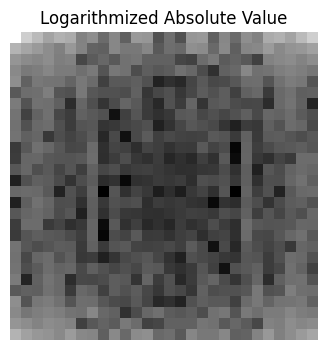

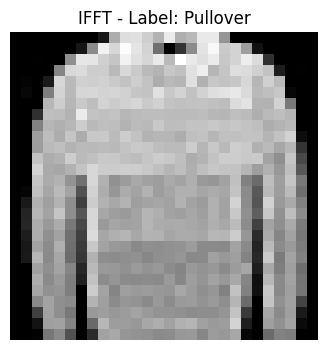

True Label: Pullover
Predicted Label: Pullover


In [34]:
example = 20
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
# Get a single test example
test_sample, test_label = next(iter(test_loader))
test_sample, test_label = test_sample[example], test_label[example]

# Make a complex number out of real and imaginary channels
complex_sample = torch.complex(test_sample[0], test_sample[1])

# Plot the absolute value logarithmized
abs_sample = torch.abs(complex_sample)
log_abs_sample = torch.log(abs_sample + 1e-7)  # Add a small constant to avoid taking log of zero

plt.figure(figsize=(4, 4))
plt.imshow(log_abs_sample.numpy(), cmap='gray')
plt.title("Logarithmized Absolute Value")
plt.axis('off')
plt.show()

# Apply the inverse Fourier transform and plot the absolute value
ifft_sample = torch.fft.ifft2(complex_sample)
ifft_abs_sample = torch.abs(ifft_sample)

plt.figure(figsize=(4, 4))
plt.imshow(ifft_abs_sample.numpy(), cmap='gray')
plt.title(f"IFFT - Label: {labels_map[test_label.item()]}")
plt.axis('off')
plt.show()

# Put the example into the trained model and predict the class
model.eval()
with torch.no_grad():
    test_sample = test_sample.unsqueeze(0).to(device)
    output = model(test_sample)
    _, predicted = torch.max(output, 1)
    predicted_label = predicted.item()

print(f"True Label: {labels_map[test_label.item()]}")
print(f"Predicted Label: {labels_map[predicted_label]}")

## Confusion Matrix and wrong samples

/home/marco/miniconda3/envs/pytorch-env/lib/python3.10/site-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


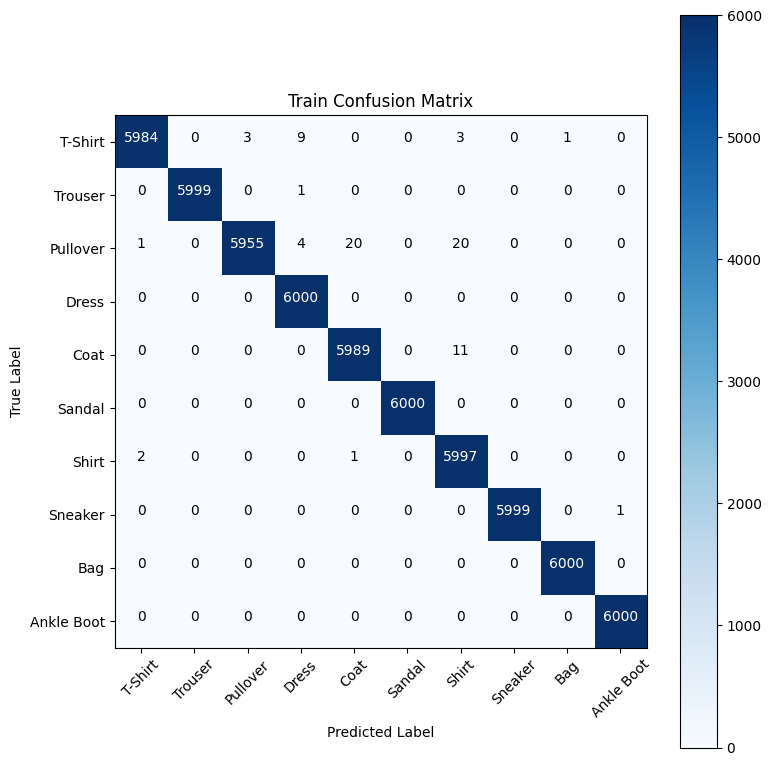

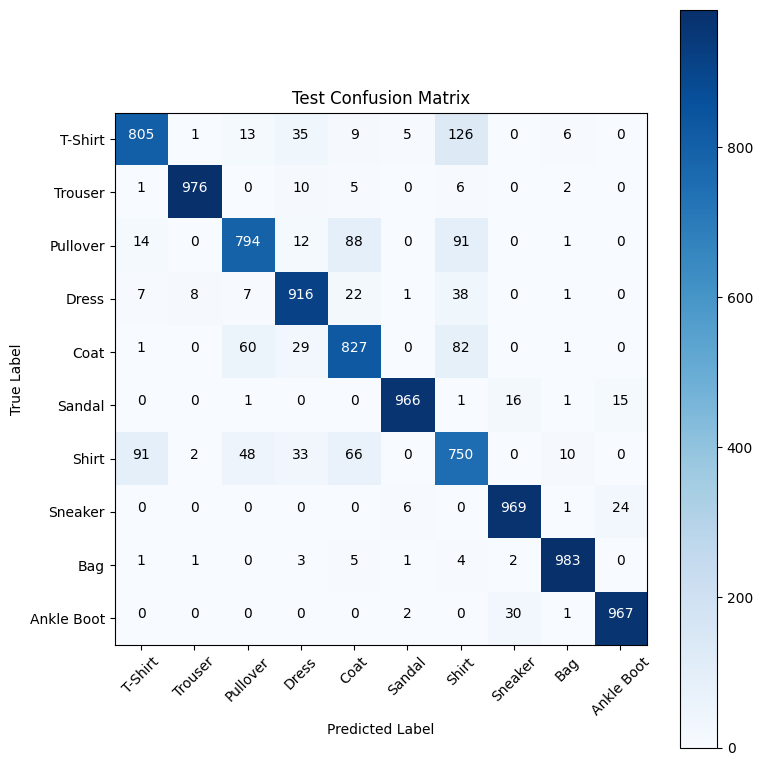

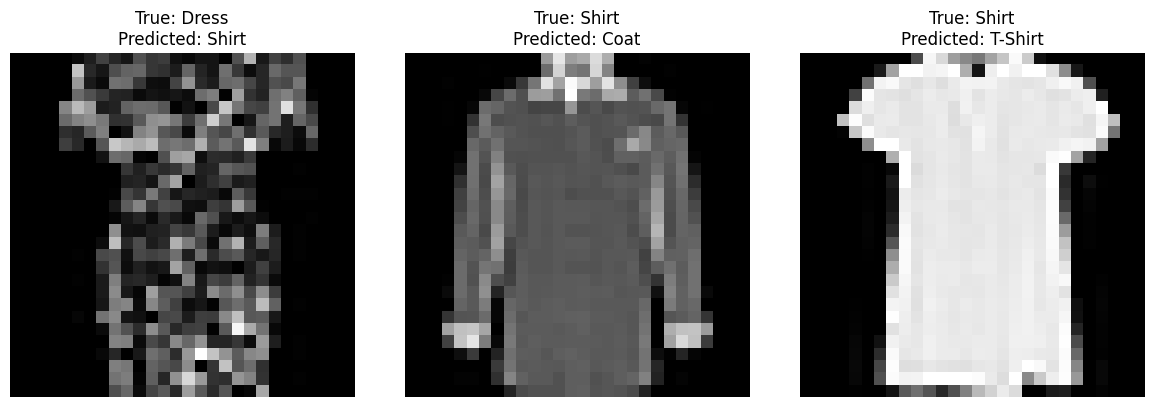

Train Accuracy: 0.9987
Test Accuracy: 0.8953


In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import random

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Add numbers to the confusion matrix
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()

# Function to get the predictions for a dataset
def get_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(target.cpu().numpy())
    return predictions, true_labels


# Get the predictions for the train and test datasets
train_predictions, train_true_labels = get_predictions(model, train_loader, device)
test_predictions, test_true_labels = get_predictions(model, test_loader, device)


# Plot the confusion matrix for the train dataset with numbers
cm_train = confusion_matrix(train_true_labels, train_predictions)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm_train, classes=list(labels_map.values()), normalize=False, title='Train Confusion Matrix')
plt.show()

# Plot the confusion matrix for the test dataset with numbers
cm_test = confusion_matrix(test_true_labels, test_predictions)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm_test, classes=list(labels_map.values()), normalize=False, title='Test Confusion Matrix')
plt.show()

# Plot 3 random examples from the wrong predictions
wrong_predictions = [i for i, (p, t) in enumerate(zip(test_predictions, test_true_labels)) if p != t]
random_indices = random.sample(wrong_predictions, 3)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, idx in enumerate(random_indices):
    img, _ = test_data[idx]
    true_label = test_true_labels[idx]
    predicted_label = test_predictions[idx]
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].set_title(f"True: {labels_map[true_label]}\nPredicted: {labels_map[predicted_label]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()
# Calculate train and test accuracy
train_accuracy = accuracy_score(train_true_labels, train_predictions)
test_accuracy = accuracy_score(test_true_labels, test_predictions)

# Print train and test accuracy
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")